In [1]:
import wrds
import pandas as pd
import numpy as np
# First Step: ciks, features, daily returns of S&P500 stocks
# Connect to WRDS
conn = wrds.Connection()
# read the provided
file_path = 'sp500_composition.xlsx'
sp500_df = pd.read_excel(file_path)

Enter your WRDS username [26491]: wz2684
Enter your password: ········


WRDS recommends setting up a .pgpass file.


Create .pgpass file now [y/n]?:  y


Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


## Phase One Merge ciks and Returns

In [3]:
# Match Daily Returns of Stocks For SP500
# msp500list stocks that is currently or ones in the index
# dsf is the daily price of the stocks
# Notice that some stocks may be exclude from the sp500 list
sp500 = conn.raw_sql("""
                        select a.*, b.date, b.ret
                        from crsp.msp500list as a,
                        crsp.dsf as b
                        where a.permno=b.permno
                        and b.date >= a.start and b.date<= a.ending
                        and b.date>='08/01/2017'
                        order by date;
                        """, date_cols=['start', 'ending', 'date'])
# Daily Price
dse = conn.raw_sql("""
                        select comnam, ncusip, namedt, nameendt,
                        permno, shrcd, exchcd, hsiccd, ticker
                        from crsp.msenames
                        """, date_cols=['namedt'])

# Merge with SP500 data
sp500_full = pd.merge(sp500, dse, how = 'left', on = 'permno')
# Append CIK Following online tutorial in WRDS

sp500_full = sp500_full.drop_duplicates()

ccm=conn.raw_sql("""
                  select gvkey, liid as iid, lpermno as permno,
                  linktype, linkprim, linkdt, linkenddt
                  from crsp.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """, date_cols=['linkdt', 'linkenddt'])
sp500ccm = pd.merge(sp500_full, ccm, how='left', on=['permno'])

sp500ccm = sp500ccm.drop_duplicates()

sp500ccm = sp500ccm[['date', 'permno', 'comnam', 'ncusip',
                     'shrcd', 'exchcd', 'ticker',
                     'gvkey', 'iid', 'start', 'ending', 'ret']]

### Add CIKs and Link with SEC Index Files using CIK

names = conn.raw_sql(""" select gvkey, cik, sic, naics, gind, gsubind from comp.names """)

# Merge sp500 constituents table with names table
sp500cik = pd.merge(sp500ccm, names, on='gvkey',  how='left')
sp500cik.head()

sp500 = sp500cik[['date', 'comnam', 'ticker', 'cik', 'ret']]

In [4]:
sp500 = sp500.sort_values(by=['ticker', 'cik', 'date'])
sp500

,date,comnam,ticker,cik,ret
3910,2017-08-01,AGILENT TECHNOLOGIES INC,A,0001090872,0.002509
3911,2017-08-01,AGILENT TECHNOLOGIES INC,A,0001090872,0.002509
3912,2017-08-01,AGILENT TECHNOLOGIES INC,A,0001090872,0.002509
3913,2017-08-01,AGILENT TECHNOLOGIES INC,A,0001090872,0.002509
3914,2017-08-01,AGILENT TECHNOLOGIES INC,A,0001090872,0.002509
...,...,...,...,...,...
7593005,2023-12-28,UNITED STATES STEEL CORP,None,None,-0.018914
7595681,2023-12-29,UNITED STATES STEEL CORP,None,None,-0.009024
7595682,2023-12-29,UNITED STATES STEEL CORP,None,None,-0.009024
7596325,2023-12-29,ALUMINUM COMPANY AMER,None,None,0.000185


In [5]:
sp500 = sp500.drop_duplicates(subset=['ticker', 'cik', 'date'], keep='last')
sp500 = sp500[sp500['ticker'].notna()]
sp500['cik'] = sp500['cik'].fillna(0).astype(int)
sp500['cik'] = sp500['cik'].astype(int)
sp500

,date,comnam,ticker,cik,ret
3916,2017-08-01,AGILENT TECHNOLOGIES INC,A,1090872,0.002509
7694,2017-08-02,AGILENT TECHNOLOGIES INC,A,1090872,0.004338
12416,2017-08-03,AGILENT TECHNOLOGIES INC,A,1090872,0.002824
16298,2017-08-04,AGILENT TECHNOLOGIES INC,A,1090872,-0.003975
21753,2017-08-07,AGILENT TECHNOLOGIES INC,A,1090872,0.012307
...,...,...,...,...,...
7576263,2023-12-22,ZAYRE CORP,ZY,109198,0.005143
7582052,2023-12-26,ZAYRE CORP,ZY,109198,0.010234
7584926,2023-12-27,ZAYRE CORP,ZY,109198,-0.000216
7591944,2023-12-28,ZAYRE CORP,ZY,109198,0.005066


As we are working on the permno code problem, an issue may arise if there exist some companies that share the same permno but have never been part of the S&P 500. We need to filter these companies out from the S&P 500 series.

In [7]:
file_path = 'sp500_composition.xlsx'
sp500_comp = pd.read_excel(file_path)

In [8]:
sp500_tick = list(set(sp500_comp['Ticker']))
sp500_filtered = sp500[sp500['ticker'].isin(sp500_tick)]
sp500_filtered['info'] = sp500_filtered['ticker'] + '_' + np.where(sp500_filtered['cik'] == 0, '', sp500_filtered['cik'].astype(str))

C:\Users\26491\AppData\Local\Temp\ipykernel_17088\3990165526.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_filtered['info'] = sp500_filtered['ticker'] + '_' + np.where(sp500_filtered['cik'] == 0, '', sp500_filtered['cik'].astype(str))


In [9]:
pivot_df = sp500_filtered.pivot_table(index='date', columns='info', values='ret', aggfunc='first')

unique_columns = {}
for col in pivot_df.columns:
    base_name = col.split('_')[0]
    if base_name not in unique_columns or len(col) > len(unique_columns[base_name]):
        unique_columns[base_name] = col

pivot_df = pivot_df[unique_columns.values()]

In [10]:
pivot_df

info,AAL_6201,AAPL_320193,AAP_1158449,AA_4281,ABBV_1551152,ABC_1140859,ABMD_815094,ABNB_1559720,ABT_1800,ACE_896159,...,XRAY_818479,XRX_1770450,XYL_1524472,X_101778,YUM_1041061,ZBH_1136869,ZBRA_877212,ZION_109380,ZMH_1136869,ZTS_1555280
date,,,,,,,,,,,,,,,,,,,,,
2017-08-01,0.012292,0.008875,0.018213,0.012505,0.006723,-0.008953,NaN,NaN,-0.000610,0.010993,...,-0.008222,0.058363,0.045302,-0.026165,0.000662,-0.008243,NaN,0.001324,-0.008243,-0.003999
2017-08-02,-0.011947,0.047251,0.003770,-0.006375,0.004689,-0.018391,NaN,NaN,0.001628,0.005740,...,-0.005852,0.002773,0.010455,0.010915,0.014431,-0.021858,NaN,0.007492,-0.021858,-0.011723
2017-08-03,0.001982,-0.009991,-0.034504,0.018087,0.003960,-0.104744,NaN,NaN,-0.001422,0.006379,...,0.003107,-0.013825,-0.006008,0.039037,-0.022971,-0.004503,NaN,-0.005031,-0.004503,0.012025
2017-08-04,0.004946,0.005271,0.004343,-0.007896,0.000000,-0.010770,NaN,NaN,0.002034,-0.000467,...,0.003912,0.003738,0.007723,0.031175,0.002271,0.006572,NaN,0.013849,0.006572,-0.002569
2017-08-07,-0.004331,0.015474,-0.013693,0.008357,0.003240,-0.003093,NaN,NaN,0.000812,-0.003271,...,0.012177,0.009001,0.000333,-0.042636,-0.000533,-0.006275,NaN,-0.007806,-0.006275,-0.004668
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.002787,-0.005548,NaN,0.001870,0.015401,0.003807,NaN,-0.009079,0.005070,0.003409,...,0.000853,NaN,0.008506,-0.002833,0.000154,0.007605,0.015454,0.008712,0.007605,0.001644
2023-12-26,-0.013976,-0.002841,NaN,0.005040,-0.002065,0.005171,NaN,-0.014773,0.001834,0.005889,...,0.009086,NaN,0.008700,0.020698,0.002000,0.009124,0.022605,0.020000,0.009124,0.002667
2023-12-27,-0.008505,0.000518,NaN,0.003900,0.001682,0.000686,NaN,-0.015643,0.005127,0.002792,...,0.002532,NaN,0.006689,-0.011928,0.004453,-0.002388,0.001053,-0.008244,-0.002388,0.007161


In [11]:
# get sp500 return series
query = """
    SELECT caldt, sprtrn
    FROM crsp.dsp500
    WHERE caldt >= '2017-08-01'
"""

# Execute the query
sp500_returns = conn.raw_sql(query)
sp500_returns.rename(columns={'caldt': 'date', 'sprtrn': 'sp500_returns'}, inplace=True)
sp500_returns['date'] = pd.to_datetime(sp500_returns['date'])
sp500_returns.set_index('date', inplace=True)
print(sp500_returns.head())

            sp500_returns
date                     
2017-08-01       0.002449
2017-08-02       0.000493
2017-08-03      -0.002184
2017-08-04       0.001889
2017-08-07       0.001647


In [12]:
return_df_clean = pivot_df

In [13]:
from sklearn.linear_model import LinearRegression
rolling_window = 90
beta_matrix = pd.DataFrame(index=return_df_clean.index, columns=return_df_clean.columns)

for ticker in return_df_clean.columns:
    stock_returns = return_df_clean[ticker]
    market_returns = sp500_returns['sp500_returns']

    for i in range(rolling_window, len(stock_returns)):
        y = stock_returns.iloc[i - rolling_window:i].values.reshape(-1, 1)
        X = market_returns.iloc[i - rolling_window:i].values.reshape(-1, 1)
        # Check for NaNs in the window and skip if present
        if not np.isnan(y).any() and not np.isnan(X).any():
            model = LinearRegression().fit(X, y)
            beta_matrix.iloc[i, beta_matrix.columns.get_loc(ticker)] = model.coef_[0][0]
print(beta_matrix.tail())

info        AAL_6201 AAPL_320193 AAP_1158449   AA_4281 ABBV_1551152  \
date                                                                  
2023-12-22  1.261832    1.055032         NaN   0.98425     0.446598   
2023-12-26  1.267743    1.058139         NaN  0.997677     0.448363   
2023-12-27  1.235129    1.043071         NaN   1.00211     0.435258   
2023-12-28  1.234783    1.043595         NaN  1.003023     0.435508   
2023-12-29  1.233206    1.042946         NaN  1.015541     0.438846   

info       ABC_1140859 ABMD_815094 ABNB_1559720  ABT_1800 ACE_896159  ...  \
date                                                                  ...   
2023-12-22    0.069287         NaN          NaN  0.384201   0.378674  ...   
2023-12-26    0.056904         NaN          NaN  0.382941    0.40247  ...   
2023-12-27    0.023074         NaN          NaN  0.393427   0.392373  ...   
2023-12-28    0.023187         NaN          NaN  0.391185   0.392134  ...   
2023-12-29    0.021946         NaN      

In [14]:
excess_return_matrix = pd.DataFrame(index=return_df_clean.index, columns=return_df_clean.columns)
for ticker in return_df_clean.columns:
    stock_returns = return_df_clean[ticker]
    betas = beta_matrix[ticker]
    excess_return_matrix[ticker] = stock_returns - (betas * sp500_returns['sp500_returns'])
print(excess_return_matrix.tail())

info        AAL_6201 AAPL_320193 AAP_1158449   AA_4281 ABBV_1551152  \
date                                                                  
2023-12-22 -0.004882   -0.007299         NaN  0.000236      0.01466   
2023-12-26 -0.019341   -0.007319         NaN  0.000818    -0.003962   
2023-12-27 -0.010271   -0.000974         NaN  0.002467      0.00106   
2023-12-28 -0.001172     0.00184         NaN  0.000739       -0.001   
2023-12-29 -0.013682   -0.002477         NaN  0.003055     0.002662   

info       ABC_1140859 ABMD_815094 ABNB_1559720  ABT_1800 ACE_896159  ...  \
date                                                                  ...   
2023-12-22    0.003692         NaN          NaN  0.004432    0.00278  ...   
2023-12-26     0.00493         NaN          NaN  0.000213   0.004186  ...   
2023-12-27    0.000653         NaN          NaN  0.004564   0.002231  ...   
2023-12-28   -0.003632         NaN          NaN  0.005411   0.007669  ...   
2023-12-29     0.00935         NaN      

In [15]:
excess_return = excess_return_matrix.iloc[103:,]

In [16]:
excess_return.to_csv('excess_return_matrix.csv', index=True)

# Phase Two Download 

In [18]:
sp500_filtered

,date,comnam,ticker,cik,ret,info
3916,2017-08-01,AGILENT TECHNOLOGIES INC,A,1090872,0.002509,A_1090872
7694,2017-08-02,AGILENT TECHNOLOGIES INC,A,1090872,0.004338,A_1090872
12416,2017-08-03,AGILENT TECHNOLOGIES INC,A,1090872,0.002824,A_1090872
16298,2017-08-04,AGILENT TECHNOLOGIES INC,A,1090872,-0.003975,A_1090872
21753,2017-08-07,AGILENT TECHNOLOGIES INC,A,1090872,0.012307,A_1090872
...,...,...,...,...,...,...
7578117,2023-12-22,ZOETIS INC,ZTS,1555280,0.001644,ZTS_1555280
7583552,2023-12-26,ZOETIS INC,ZTS,1555280,0.002667,ZTS_1555280
7586151,2023-12-27,ZOETIS INC,ZTS,1555280,0.007161,ZTS_1555280
7590111,2023-12-28,ZOETIS INC,ZTS,1555280,0.001321,ZTS_1555280


In [19]:
missing = [sp for sp in sp500_tick if sp not in sp500_filtered['ticker'].values]
len(missing)

79

In [20]:
# 79 missing but it is allright as they are not really in the period
sp500_comp[sp500_comp['Ticker'] == 'CPGX'] 

,Date,Company Name,Ticker
3140,2015-09-30,COLUMBIA PIPELINE GROUP INC,CPGX
3774,2015-12-31,COLUMBIA PIPELINE GROUP INC,CPGX
4179,2016-03-31,COLUMBIA PIPELINE GROUP INC,CPGX
4693,2016-06-30,COLUMBIA PIPELINE GROUP INC,CPGX


In [21]:
df = excess_return_matrix.copy()
matching_columns = [col for col in df.columns if '_' in col and not any(char.isdigit() for char in col.split('_', 1)[1])]

In [22]:
matching_columns

['DISCK_', 'DPS_']

In [23]:
ticker_cik_dict = {}

for info in sp500_filtered['info']:
    parts = info.split('_')
    if len(parts) == 2 and parts[1].isdigit():
        ticker_cik_dict[parts[0]] = int(parts[1])

In [24]:
len(list(ticker_cik_dict.keys()))

662

In [123]:
info_table = sp500_df.copy()

In [125]:
info_table['Date'] = pd.to_datetime(info_table['Date'])
filtered_info_table = info_table[info_table['Date'] > pd.Timestamp('2018-01-01')]
info_table_sorted = filtered_info_table.sort_values(by='Date')
info_table_sorted.reset_index(drop=True, inplace=True)

In [127]:
info_table_sorted['cik'] = info_table_sorted['Ticker'].apply(lambda x: ticker_cik_dict.get(x, 0))

In [129]:
info_table_sorted

,Date,Company Name,Ticker,cik
0,2018-12-31,AON PLC,AON,315293
1,2018-12-31,F M C CORP,FMC,37785
2,2018-12-31,WILLIAMS COS,WMB,107263
3,2018-12-31,U S BANCORP DEL,USB,36104
4,2018-12-31,BRISTOL MYERS SQUIBB CO,BMY,14272
...,...,...,...,...
9072,2023-12-29,TARGA RESOURCES CORP,TRGP,1389170
9073,2023-12-29,FEDERAL REALTY INVESTMENT TR NEW,FRT,34903
9074,2023-12-29,K L A CORP,KLAC,319201
9075,2023-12-29,INCYTE CORP,INCY,879169


In [131]:
Q42018 = info_table_sorted[(info_table_sorted['Date'] < pd.Timestamp('2019-01-31'))]
Q42018_cik = Q42018['cik']
Q42018_cik.to_csv('Q42018.txt', sep='\t', index=False)

In [133]:
years = [2018, 2019, 2020, 2021, 2022, 2023]
quarters = {
    'Q1': ('01-31', '04-30'),
    'Q2': ('04-30', '07-31'),
    'Q3': ('07-31', '10-31'),
    'Q4': ('10-31', '12-31')
}

for year in years:
    for quarter, (start_date, end_date) in quarters.items():
        filtered_df = info_table_sorted[
            (info_table_sorted['Date'] > pd.Timestamp(f'{year}-{start_date}')) &
            (info_table_sorted['Date'] <= pd.Timestamp(f'{year}-{end_date}')) &
            (info_table_sorted['cik'] != 0)
        ]
        
        filtered_cik = filtered_df['cik']
        print(len(filtered_cik)) 
        filename = f'{quarter}{year}.txt'
        filtered_cik.to_csv(filename, sep='\t', index=False, header=False)

        print(f"Saved {filename}")

0
Saved Q12018.txt
0
Saved Q22018.txt
0
Saved Q32018.txt
504
Saved Q42018.txt
0
Saved Q12019.txt
0
Saved Q22019.txt
504
Saved Q32019.txt
504
Saved Q42019.txt
504
Saved Q12020.txt
504
Saved Q22020.txt
504
Saved Q32020.txt
504
Saved Q42020.txt
504
Saved Q12021.txt
504
Saved Q22021.txt
504
Saved Q32021.txt
504
Saved Q42021.txt
504
Saved Q12022.txt
503
Saved Q22022.txt
502
Saved Q32022.txt
503
Saved Q42022.txt
503
Saved Q12023.txt
503
Saved Q22023.txt
0
Saved Q32023.txt
503
Saved Q42023.txt


# Phase Three Construct 

In [26]:
"""
Program to provide generic parsing for all files in user-specified directory.
The program assumes the input files have been scrubbed,
  i.e., HTML, ASCII-encoded binary, and any other embedded document structures that are not
  intended to be analyzed have been deleted from the file.

Dependencies:
    Python:  Load_MasterDictionary.py
    Data:    LoughranMcDonald_MasterDictionary_XXXX.csv

The program outputs:
   1.  File name
   2.  File size (in bytes)
   3.  Number of words (based on LM_MasterDictionary
   4.  Proportion of positive words (use with care - see LM, JAR 2016)
   5.  Proportion of negative words
   6.  Proportion of uncertainty words
   7.  Proportion of litigious words
   8.  Proportion of modal-weak words
   9.  Proportion of modal-moderate words
  10.  Proportion of modal-strong words
  11.  Proportion of constraining words (see Bodnaruk, Loughran and McDonald, JFQA 2015)
  12.  Number of alphanumeric characters (a-z, A-Z)
  13.  Number of digits (0-9)
  14.  Number of numbers (collections of digits)
  15.  Average number of syllables
  16.  Average word length
  17.  Vocabulary (see Loughran-McDonald, JF, 2015)

  ND-SRAF
  McDonald 2016/06 : updated 2018/03
"""

import csv
import glob
import re
import json
import string
import sys
import time
import Load_MasterDictionary as LM
import numpy as np
import pandas as pd

In [42]:
# User defined directory for files to be parsed
TARGET_FILES = r'E:/ALLEXTRACTED_FILINGS/*.*'

# User defined file pointer to LM dictionary
MASTER_DICTIONARY_FILE = r'C:/Users/26491/LoughranMcDonald_MasterDictionary_2018.csv'

# User defined output file
MATRIX_FILE = r'E:/ALLEXTRACTED_FILINGS/Matrix.csv'

# User defined output file
PROPORTION_FILE = r'E:/ALLEXTRACTED_FILINGS/Proportion.csv'

# User defined output file
# OUTPUT_FILE = r'/E:/ALLEXTRACTED_FILINGS/Parser.csv'

# Setup output
OUTPUT_FIELDS = ['file name,', 'file size,', 'number of words,', '% positive,', '% negative,',
                 '% uncertainty,', '% litigious,', '% modal-weak,', '% modal moderate,',
                 '% modal strong,', '% constraining,', '# of alphabetic,', '# of digits,',
                 '# of numbers,', 'avg # of syllables per word,', 'average word length,', 'vocabulary']

lm_dictionary = LM.load_masterdictionary(MASTER_DICTIONARY_FILE, True)

# Assuming lm_dictionary contains all the negative words from the master dictionary
negative_words = [word for word in lm_dictionary if lm_dictionary[word].negative]

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  C:/Users/26491/LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



In [44]:
def get_data(doc):

    vdictionary = {}
    _odata = [0] * 17
    total_syllables = 0
    word_length = 0
    
    tokens = re.findall('\w+', doc)  # Note that \w+ splits hyphenated words
    for token in tokens:
        if not token.isdigit() and len(token) > 1 and token in lm_dictionary:
            _odata[2] += 1  # word count
            word_length += len(token)
            if token not in vdictionary:
                vdictionary[token] = 1
            if lm_dictionary[token].positive: _odata[3] += 1
            if lm_dictionary[token].negative: _odata[4] += 1
            if lm_dictionary[token].uncertainty: _odata[5] += 1
            if lm_dictionary[token].litigious: _odata[6] += 1
            if lm_dictionary[token].weak_modal: _odata[7] += 1
            if lm_dictionary[token].moderate_modal: _odata[8] += 1
            if lm_dictionary[token].strong_modal: _odata[9] += 1
            if lm_dictionary[token].constraining: _odata[10] += 1
            total_syllables += lm_dictionary[token].syllables

    _odata[11] = len(re.findall('[A-Z]', doc))
    _odata[12] = len(re.findall('[0-9]', doc))
    # drop punctuation within numbers for number count
    doc = re.sub('(?!=[0-9])(\.|,)(?=[0-9])', '', doc)
    doc = doc.translate(str.maketrans(string.punctuation, " " * len(string.punctuation)))
    _odata[13] = len(re.findall(r'\b[-+\(]?[$€£]?[-+(]?\d+\)?\b', doc))
    _odata[14] = total_syllables / _odata[2]
    _odata[15] = word_length / _odata[2]
    _odata[16] = len(vdictionary)
    
    # Convert counts to %
    for i in range(3, 10 + 1):
        _odata[i] = (_odata[i] / _odata[2]) * 100
    # Vocabulary
        
    return _odata

In [46]:
def get_proportion(tf_matrix, idf_matrix, doc_length_matrix):
    """
    Calculate the modified TF-IDF proportions and weights for each document based on the provided formula.
    """
    num_docs = tf_matrix.shape[0]  # Total number of documents (N)
    
    # Calculate document frequency (DF) for each word
    df_vector = np.sum(idf_matrix, axis=0)  # How many documents each word appears in

    # Calculate IDF for each word
    idf_vector = np.log((num_docs) / (df_vector + 1))  # IDF with smoothing (add 1 to avoid division by 0)

    # Calculate the average word count (a_j) for each document
    avg_word_count = np.mean(doc_length_matrix)  # Average word count per document

    # Initialize the adjusted TF-IDF matrix
    tfidf_matrix = np.zeros_like(tf_matrix)

    # Apply the adjusted TF formula and calculate the final TF-IDF
    for doc_idx in range(num_docs):
        for word_idx in range(tf_matrix.shape[1]):
            tf_ij = tf_matrix[doc_idx, word_idx]
            if tf_ij > 0:  # Only apply TF-IDF if tf_ij >= 1
                a_j = avg_word_count  # Use the average word count of document j
                # Adjusted TF: (1 + log(tf_ij)) / (1 + log(a_j))
                adjusted_tf = (1 + np.log(tf_ij)) / (1 + np.log(a_j))
                # Final TF-IDF: adjusted TF * IDF
                tfidf_matrix[doc_idx, word_idx] = adjusted_tf * idf_vector[word_idx]
            else:
                # If tf_ij == 0, set the weight to 0 as per the formula
                tfidf_matrix[doc_idx, word_idx] = 0

    # Sum of TF-IDF scores for each document
    tfidf_sums = np.sum(tfidf_matrix, axis=1)

    # Calculate proportion weights by dividing the TF-IDF sum by the total number of words in the document
    proportion_weights = tfidf_sums / doc_length_matrix.flatten()

    return tfidf_matrix, proportion_weights

In [147]:
def main():
    # Initialize matrices
    file_list = glob.glob(TARGET_FILES)
    num_docs = len(file_list)
    num_words = len(negative_words)
    
    # Initialize TF, IDF, and doc_length matrices
    tf_matrix = np.zeros((num_docs, num_words))
    idf_matrix = np.zeros((num_docs, num_words))
    doc_length_matrix = np.zeros((num_docs, 1))
    
    # Create lists to store 'filing_time' and 'cik' for each document
    filling_time_list = []
    cik_list = []
    
    # Process each document and populate matrices
    for doc_idx, file in enumerate(file_list):
        print(f"Processing file: {file}")
        try:
            with open(file, 'r', encoding='UTF-8', errors='ignore') as f_in:
                json_data = json.load(f_in)
        except json.JSONDecodeError:
            print(f"Error: Could not parse JSON in the file {file}. Skipping this file.")
            continue
        
        # Extract text and metadata from the JSON
        doc = json_data.get('full_text', '').upper()  # Get the document text
        filing_date = json_data.get('filing_date', '')
        cik = json_data.get('cik', '')
    
        # Append filing date and cik to lists
        filling_time_list.append(filing_date)
        cik_list.append(cik)
    
        # Use the get_data function to extract data for the current document
        output_data = get_data(doc)
    
        # Store document length (number of words)
        doc_length_matrix[doc_idx] = output_data[2]
    
        # Tokenize the document text
        tokens = re.findall(r'\w+', doc)
    
        # Populate TF and IDF matrices
        for token in tokens:
            if token in negative_words:
                word_idx = negative_words.index(token)
                tf_matrix[doc_idx, word_idx] += 1  # Increment term frequency
                idf_matrix[doc_idx, word_idx] = 1  # Mark presence of word in the document
    
    # Calculate proportions using the get_proportion function
    tfidf_matrix, proportion_weights = get_proportion(tf_matrix, idf_matrix, doc_length_matrix)
    
    # Write TF-IDF information to MATRIX_OUTPUT_FILE
    with open(MATRIX_FILE, 'w', newline='') as f_matrix:
        matrix_writer = csv.writer(f_matrix, lineterminator='\n')
    
        # Write header (document name + each negative word)
        header = ['file name'] + negative_words
        matrix_writer.writerow(header)
    
        # Write each document's TF-IDF scores
        for doc_idx, file in enumerate(file_list):
            row = [file] + list(tfidf_matrix[doc_idx])
            matrix_writer.writerow(row)
    
    # Write the proportion weights to PROPORTION_OUTPUT_FILE
    with open(PROPORTION_FILE, 'w', newline='') as f_proportion:
        proportion_writer = csv.writer(f_proportion, lineterminator='\n')
    
        # Write header
        proportion_writer.writerow(['file name', 'proportion_weight', 'filing_time', 'cik'])
    
        # Write each document's proportion weight
        for doc_idx, file in enumerate(file_list):
            if doc_idx < len(filling_time_list):  # Ensure we're within bounds for valid entries
                proportion_writer.writerow([file, proportion_weights[doc_idx], filling_time_list[doc_idx], cik_list[doc_idx]])

if __name__ == '__main__':
    import time
    print('\n' + time.strftime('%c') + '\nGeneric_Parser.py\n')
    main()
    print('\n' + time.strftime('%c') + '\nNormal termination.')


Wed Oct  2 02:56:51 2024
Generic_Parser.py

Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_0001000228-19-000030.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_0001000228-19-000067.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_0001000228-20-000034.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_0001000228-20-000055.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_0001000228-20-000066.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2021_0001000228-21-000036.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2021_0001000228-21-000060.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2021_0001000228-21-000081.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2022_0001000228-22-000033.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2022_0001000228-22-000056.json
Processing file: E:/ALLEXTRACTED_FILINGS\1000228_10Q_2022_0001000228-22-000068.json
Processing file: E:/ALLEXTRACTE

C:\Users\26491\AppData\Local\Temp\ipykernel_17088\1232392368.py:37: RuntimeWarning: invalid value encountered in divide
  proportion_weights = tfidf_sums / doc_length_matrix.flatten()



Wed Oct  2 04:25:40 2024
Normal termination.


In [4]:
tf_idf = pd.read_csv("Matrix.csv")
tf_idf

,file name,ABANDON,ABANDONED,ABANDONING,ABANDONMENT,ABANDONMENTS,ABANDONS,ABDICATED,ABDICATES,ABDICATING,...,WRITEDOWN,WRITEDOWNS,WRITEOFF,WRITEOFFS,WRONG,WRONGDOING,WRONGDOINGS,WRONGFUL,WRONGFULLY,WRONGLY
0,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,0.0,0.0,0.739825,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,0.0,0.0,0.739825,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,0.0,0.0,0.739825,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,0.0,0.0,0.739825,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,0.0,0.0,0.436953,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452864,0.0,0.0
6388,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452864,0.0,0.0
6389,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.452864,0.0,0.0
6390,E:/ALLEXTRACTED_FILINGS\Matrix.csv,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [6]:
term_weight = pd.read_csv('Proportion.csv')
term_weight

,file name,proportion_weight,filing_time,cik
0,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,0.001963,2019/5/7,1000228
1,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,0.002260,2019-11-05,1000228
2,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,0.001870,2020-05-05,1000228
3,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,0.001586,2020-08-04,1000228
4,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,0.001355,2020-11-02,1000228
...,...,...,...,...
6385,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,0.000992,2019/6/4,98246
6386,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,0.001260,2019-12-05,98246
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,0.001159,2020-06-09,98246
6388,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,0.001217,2020-08-27,98246


In [8]:
df = term_weight.copy()
df['quantile'] = pd.qcut(df['proportion_weight'], 5, labels=False) + 1
df.drop(['proportion_weight'], axis=1, inplace=True)
df

,file name,filing_time,cik,quantile
0,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019/5/7,1000228,5
1,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019-11-05,1000228,5
2,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-05-05,1000228,5
3,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-08-04,1000228,5
4,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-11-02,1000228,5
...,...,...,...,...
6385,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019/6/4,98246,4
6386,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-12-05,98246,4
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-06-09,98246,4
6388,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-08-27,98246,4


In [179]:
# Example demonstration
data = {
    'AAPL': [0.01, 0.02, -0.01, 0.03, -0.02, 0.01, np.nan, 0.04],
    'MSFT': [0.02, np.nan, 0.01, -0.02, 0.03, 0.01, 0.02, -0.01],
    'GOOG': [0.03, 0.01, -0.02, np.nan, 0.01, 0.02, 0.03, 0.00]
}

dfs = pd.DataFrame(data, index=pd.date_range(start='2023-01-01', periods=8))
df_filled = dfs.fillna(0)
cumulative_returns_3d = (df_filled + 1).rolling(window=3).apply(lambda x: x.prod(), raw=True) - 1
next_3_day_cumulative_returns = cumulative_returns_3d.shift(-3)

In [181]:
next_3_day_cumulative_returns 

,AAPL,MSFT,GOOG
2023-01-01,0.040094,-0.010200,-0.010200
2023-01-02,-0.000694,0.019494,-0.010200
2023-01-03,0.019494,0.019494,0.030200
2023-01-04,-0.010200,0.061106,0.061106
2023-01-05,0.050400,0.019898,0.050600
2023-01-06,NaN,NaN,NaN
2023-01-07,NaN,NaN,NaN
2023-01-08,NaN,NaN,NaN


In [183]:
cumulative_returns_3d.shift(-3) 

,AAPL,MSFT,GOOG
2023-01-01,0.040094,-0.010200,-0.010200
2023-01-02,-0.000694,0.019494,-0.010200
2023-01-03,0.019494,0.019494,0.030200
2023-01-04,-0.010200,0.061106,0.061106
2023-01-05,0.050400,0.019898,0.050600
2023-01-06,NaN,NaN,NaN
2023-01-07,NaN,NaN,NaN
2023-01-08,NaN,NaN,NaN


In [185]:
[0.02, -0.01, 0.03]

[0.02, -0.01, 0.03]

In [187]:
(1+0.02)*(1-0.01)*(1+0.03) - 1

0.040094000000000074

In [207]:
matching_return = excess_return.fillna(0)
matching_return = (matching_return + 1).rolling(window=3).apply(lambda x: x.prod(), raw=True) - 1
matching_return = matching_return.shift(-3)

C:\Users\26491\AppData\Local\Temp\ipykernel_17088\183743432.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  matching_return = excess_return.fillna(0)


In [195]:
df

,file name,filing_time,cik,quantile
0,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019/5/7,1000228,5
1,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019-11-05,1000228,5
2,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-05-05,1000228,5
3,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-08-04,1000228,5
4,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-11-02,1000228,5
...,...,...,...,...
6385,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019/6/4,98246,4
6386,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-12-05,98246,4
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-06-09,98246,4
6388,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-08-27,98246,4


In [215]:
matching_return.columns = [
    int(col.split('_')[1]) if '_' in col and col.split('_')[1].isdigit() else col.split('_')[1]
    for col in matching_return.columns
]

In [217]:
matching_return

,6201,320193,1158449,4281,1551152,1140859,815094,1559720,1800,896159,...,818479,1770450,1524472,101778,1041061,1136869,877212,109380,1136869,1555280
date,,,,,,,,,,,,,,,,,,,,,
2017-12-27,0.001217,0.002208,0.059954,0.007296,-0.002501,0.009349,0.0,0.0,0.018750,-0.025968,...,0.016272,-0.000392,-0.006378,0.017703,-0.014264,0.030697,0.000000,-0.008055,0.030697,-0.013200
2017-12-28,-0.020849,-0.008326,0.064741,-0.003211,0.010656,0.007019,0.0,0.0,0.016088,-0.025203,...,0.003141,-0.014354,0.002083,0.026316,-0.022205,0.017681,0.000000,-0.027936,0.017681,-0.010735
2017-12-29,-0.022004,-0.007274,0.095733,0.039835,0.004994,0.001090,0.0,0.0,0.012116,-0.027230,...,0.007690,-0.001745,0.001736,0.053080,-0.007238,0.017148,0.000000,-0.027466,0.017148,-0.006219
2018-01-02,-0.036062,-0.011907,0.038572,0.032107,0.005976,-0.009334,0.0,0.0,-0.014383,0.003599,...,0.001862,-0.001218,0.002887,0.012098,0.000240,-0.000601,0.000000,-0.021881,-0.000601,0.010509
2018-01-03,-0.024677,-0.007715,0.026759,0.038195,-0.020056,0.009741,0.0,0.0,-0.014387,-0.006553,...,0.014292,0.017164,-0.002005,0.004466,0.006926,-0.001368,0.000000,-0.018601,-0.001368,0.021069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,-0.030551,-0.006461,0.000000,0.004028,-0.003904,0.001935,0.0,0.0,0.010216,0.014144,...,0.009648,0.000000,0.008690,-0.013959,0.000040,0.005817,0.013106,0.001633,0.005817,0.004347
2023-12-26,-0.024957,-0.001614,0.000000,0.006272,0.002721,0.006341,0.0,0.0,0.008101,0.018108,...,0.006169,0.000000,0.007591,-0.038749,0.003757,0.003138,-0.006237,-0.020128,0.003138,0.010757
2023-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [219]:
df

,file name,filing_time,cik,quantile
0,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019/5/7,1000228,5
1,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019-11-05,1000228,5
2,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-05-05,1000228,5
3,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-08-04,1000228,5
4,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-11-02,1000228,5
...,...,...,...,...
6385,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019/6/4,98246,4
6386,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-12-05,98246,4
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-06-09,98246,4
6388,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-08-27,98246,4


In [233]:
def get_closest_trade_date(date, trade_dates):
    future_dates = trade_dates[trade_dates >= date]
    if not future_dates.empty:
        return future_dates[0]
    return None
trade_dates = matching_return.index

df['filing_time'] = pd.to_datetime(df['filing_time'], format='mixed', dayfirst=False, errors='coerce')

df['return'] = df.apply(
    lambda row: matching_return.loc[get_closest_trade_date(row['filing_time'], trade_dates), row['cik']]
    if (get_closest_trade_date(row['filing_time'], trade_dates) is not None and row['cik'] in matching_return.columns)
    else None,
    axis=1
)


In [237]:
df

,file name,filing_time,cik,quantile,return
0,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019-05-07,1000228,5,0.033518
1,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2019_00010...,2019-11-05,1000228,5,0.01342
2,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-05-05,1000228,5,-0.011072
3,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-08-04,1000228,5,-0.033602
4,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2020_00010...,2020-11-02,1000228,5,-0.056295
...,...,...,...,...,...
6385,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-06-04,98246,4,-0.051926
6386,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-12-05,98246,4,-0.009038
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-06-09,98246,4,-0.029276
6388,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-08-27,98246,4,0.000045


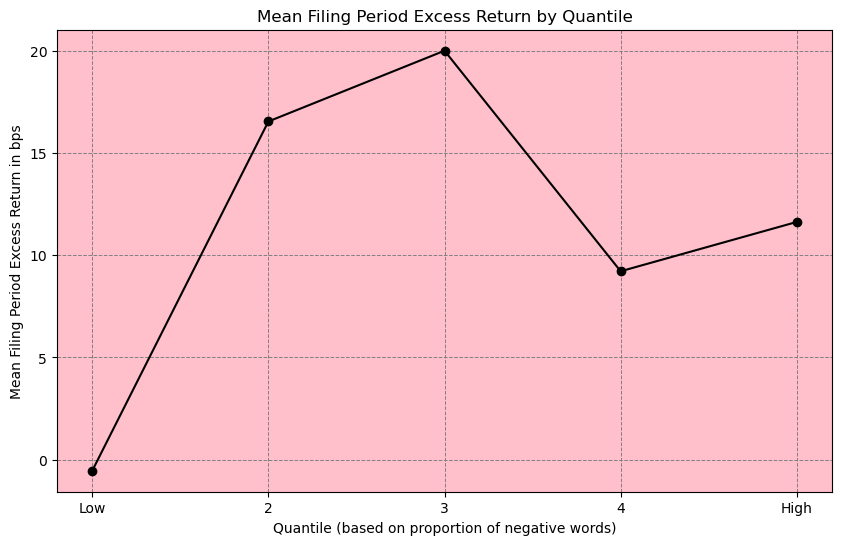

In [273]:
import matplotlib.pyplot as plt
# Convert the 'return' column to numeric, forcing non-numeric values to NaN
df['return'] = pd.to_numeric(df['return'], errors='coerce')
median_returns = df.groupby('quantile')['return'].mean()
plt.figure(figsize=(10, 6))
plt.plot(median_returns.index, median_returns.values * 100 * 100, marker='o', linestyle='-', color='black')
plt.title('Mean Filing Period Excess Return by Quantile')
plt.xlabel('Quantile (based on proportion of negative words)')
plt.ylabel('Mean Filing Period Excess Return in bps')
plt.xticks(median_returns.index, ['Low', '2', '3', '4', 'High'])
plt.gca().set_facecolor('#FFC0CB')  
plt.grid(True, linestyle='--', linewidth=0.7, color='gray')
plt.show()

In [247]:
set(df['quantile'])

{1, 2, 3, 4, 5}

In [249]:
median_returns 

quantile
1    0.000000
2    0.000000
3    0.000000
4   -0.000325
5    0.001160
Name: return, dtype: float64

In [277]:
df[df['quantile'] == 1]

,file name,filing_time,cik,quantile,return
5,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2021_00010...,2021-05-04,1000228,1,-0.003629
8,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2022_00010...,2022-05-03,1000228,1,0.055049
9,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2022_00010...,2022-08-02,1000228,1,-0.010094
10,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2022_00010...,2022-11-01,1000228,1,0.028683
11,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2023_00010...,2023-05-09,1000228,1,0.020300
...,...,...,...,...,...
6372,E:/ALLEXTRACTED_FILINGS\97476_10Q_2023_0000097...,2023-04-26,97476,1,-0.018155
6380,E:/ALLEXTRACTED_FILINGS\97745_10Q_2021_0000097...,2021-11-04,97745,1,-0.033624
6381,E:/ALLEXTRACTED_FILINGS\97745_10Q_2022_0000097...,2022-05-06,97745,1,-0.004684
6382,E:/ALLEXTRACTED_FILINGS\97745_10Q_2022_0000097...,2022-08-05,97745,1,-0.011658


In [275]:
df[df['quantile'] == 4]

,file name,filing_time,cik,quantile,return
6,E:/ALLEXTRACTED_FILINGS\1000228_10Q_2021_00010...,2021-08-03,1000228,4,-0.043838
26,E:/ALLEXTRACTED_FILINGS\1001082_10Q_2019_00015...,2019-05-03,1001082,4,0.018006
27,E:/ALLEXTRACTED_FILINGS\1001082_10Q_2019_00015...,2019-11-07,1001082,4,0.035380
28,E:/ALLEXTRACTED_FILINGS\1001082_10Q_2020_00015...,2020-05-07,1001082,4,0.085894
29,E:/ALLEXTRACTED_FILINGS\1001082_10Q_2020_00015...,2020-08-07,1001082,4,-0.007003
...,...,...,...,...,...
6350,E:/ALLEXTRACTED_FILINGS\96943_10Q_2022_0000096...,2022-07-28,96943,4,0.016406
6385,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-06-04,98246,4,-0.051926
6386,E:/ALLEXTRACTED_FILINGS\98246_10Q_2019_0000098...,2019-12-05,98246,4,-0.009038
6387,E:/ALLEXTRACTED_FILINGS\98246_10Q_2020_0000098...,2020-06-09,98246,4,-0.029276


# Conclusion 

It appears that the "McDonald's effect" does not persist based on our findings, and this could be attributed to several factors.

Firstly, the paper indicates that companies have become less inclined to use negative language, possibly due to an increased awareness of how public perception and investor reactions are shaped by sentiment analysis. This shift towards more neutral or positive language could diminish the impact of traditionally negative indicators, leading to reduced predictive power in our analysis.

Secondly, it's important to note that we are only analyzing 10-Q filings, which provide a retrospective view of a company's financial health rather than forward-looking performance forecasts. As 10-Qs are intended primarily to update investors on past performance and current risks, they may not fully capture the optimistic or pessimistic outlook that could directly influence future stock returns.

Lastly, the dictionary we used for sentiment analysis is from 2018, which may limit its effectiveness in capturing evolving language trends. Corporate communication styles and the terminology used in financial reports have likely changed over time, leading to discrepancies between the dictionary's vocabulary and the language currently in use. An outdated dictionary might fail to accurately classify sentiment, thereby reducing the reliability of our findings.

To address these challenges, we may consider updating our sentiment dictionary, incorporating more recent language trends, and expanding the analysis to include other documents such as earnings forecasts or conference call transcripts that contain forward-looking statements, providing a more holistic view of sentiment in relation to company performance.